In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')
one_year_ago_str = '20210601'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)

sub_category_list = pd.read_sql(query_sub_category, engine)



In [10]:
import collections
df_rs70_category_week = pd.DataFrame()  #多筆每日強勢細產業

sub_category_list.rename(columns={'stock_id': '證券代號'}, inplace=True)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
data_date_list = collections.Counter(stock_df_raw['Date'].sort_values(ascending=False))

for day in data_date_list:
        day = day.strftime('%Y-%m-%d')
        # 取每天RS大於90的產業出來
        stock_df_today = stock_df_raw[stock_df_raw['Date']==day].copy()  
        stock_df_today.sort_values(by=['60RS_rank'], inplace=True)

        stock_df_today90 = stock_df_today[stock_df_today['60RS_rank']>90]

        merged_rs_sub = pd.merge(stock_df_today90, sub_category_list, on='證券代號', how='inner')  #RS超過90的
        merged_sub = pd.merge(stock_df_today, sub_category_list, on='證券代號', how='inner')  # 全部股票

        cols = ['Date', '證券代號', 'stock_name','60RS_rank','main_category','sub_category']
        merged_rs_sub = merged_rs_sub[cols]
        merged_sub = merged_sub[cols]

        #找細產業別 跟 母體
        df_rs70_sub_category = collections.Counter(merged_rs_sub['sub_category'])
        df_all_sub_category = collections.Counter(merged_sub['sub_category'])

        df_sub_category = pd.DataFrame()
        for i in df_rs70_sub_category:
                sub_category = {
                "date": [day],
                "sub_category": [i],
                "main_rank": [df_rs70_sub_category[i]],
                "all": [df_all_sub_category[i]],
                "pen": [round((df_rs70_sub_category[i]/df_all_sub_category[i])*100,2)]}

                df_sub_category_temp = pd.DataFrame(sub_category)
                df_sub_category = pd.concat([df_sub_category,df_sub_category_temp])
                df_sub_category.sort_values(by=['pen'], ascending=False, inplace=True)

        df_rs70_category_week = pd.concat([df_rs70_category_week,df_sub_category])

                


In [11]:
compare_df = pd.DataFrame()
countdown = 60  #看輪動天數
pen = 40

for day in data_date_list:
        day_change = day.strftime('%Y-%m-%d')
        countdown -= 1 
        df_rs = pd.DataFrame()
        if(countdown>0):   
                getIndex = list(data_date_list).index(day) # 取index 找下一天
                day_before = list(data_date_list)[getIndex+1].strftime('%Y-%m-%d')
                df_rs70_category_1 = df_rs70_category_week[(df_rs70_category_week['date'] == day_change) &(df_rs70_category_week['main_rank'] > 2) & (df_rs70_category_week['pen'] > pen)]
                df_rs70_category_2 = df_rs70_category_week[(df_rs70_category_week['date'] == day_before) &(df_rs70_category_week['main_rank'] > 2) & (df_rs70_category_week['pen'] > pen)]

                sub_category_list_now = list(df_rs70_category_1['sub_category'])
                sub_category_before = list(df_rs70_category_2['sub_category'])
                compare_add = [x for x in sub_category_list_now if x not in sub_category_before] #新進入名單
                compare_remove = [x for x in sub_category_before if x not in sub_category_list_now] #新進入名單
                compare_list = {
                "Date": [day_change],
                "add": [compare_add],
                "remove": [compare_remove],
                "add_count": [len(compare_add)],
                "remove_count": [len(compare_remove)],
                "diff_count": [len(compare_add) - len(compare_remove)]}

                compare_list_temp = pd.DataFrame(compare_list)
                compare_df = pd.concat([compare_df,compare_list_temp])

In [12]:
compare_df30 = compare_df.iloc[:60]
compare_df30['Date'] = pd.to_datetime(compare_df30['Date'])
twse_index = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數'].copy()
twse_index['Date'] = pd.to_datetime(twse_index['Date'])
merged_hist = pd.merge(compare_df30, twse_index, on='Date', how='inner')  # 全部股票

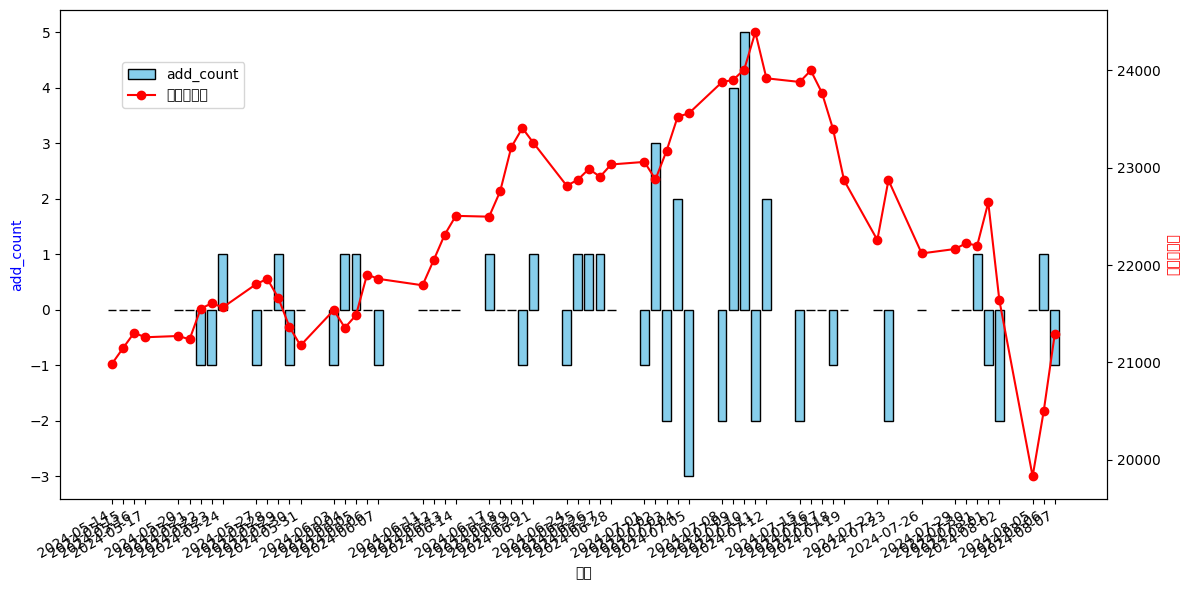

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# 禁用特定类型的警告
#warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')
warnings.filterwarnings("ignore", category=UserWarning)

# 假设 compare_df30 和 merged_hist 的数据如下
compare_df30_data = {
    'date': merged_hist['Date'],
    'diff_count': merged_hist['diff_count']
}

merged_hist_data = {
    'date': merged_hist['Date'],
    '價格指數值': merged_hist['價格指數值']
}

compare_df30_df = pd.DataFrame(compare_df30_data)
merged_hist_df = pd.DataFrame(merged_hist_data)

# 确保日期列为 datetime 类型
compare_df30_df['date'] = pd.to_datetime(compare_df30_df['date'])
merged_hist_df['date'] = pd.to_datetime(merged_hist_df['date'])

# 创建图表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制 compare_df30 的条形图
ax1.bar(compare_df30_df['date'], compare_df30_df['diff_count'], color='skyblue', edgecolor='black', label='add_count')

# 设置第一个 y 轴的标签
ax1.set_ylabel('add_count', color='blue')
ax1.set_xlabel('日期')



# 設置x軸刻度為實際存在的日期
ax1.set_xticks(compare_df30_df['date'])

# 格式化 x 轴为日期格式
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

# 自动旋转日期标签以避免重叠
fig.autofmt_xdate()

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 绘制 merged_hist 的折线图
ax2.plot(merged_hist_df['date'], merged_hist_df['價格指數值'], color='red', marker='o', linestyle='-', label='價格指數值')
ax2.set_xticks(merged_hist_df['date'])

# 设置第二个 y 轴的标签
ax2.set_ylabel('價格指數值', color='red')

# 添加图例
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# 自动调整布局以适应标签
fig.tight_layout()

# 显示图表
plt.show()

# =============================
# 创建图表
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # 绘制 compare_df30 的条形图
# ax1.bar(compare_df30_df['date'], compare_df30_df['diff_count'], color='skyblue', edgecolor='black', label='add_count')

# # 设置第一个 y 轴的标签
# ax1.set_ylabel('add_count', color='blue')
# ax1.set_xlabel('日期')



# # 設置x軸刻度為實際存在的日期
# ax1.set_xticks(compare_df30_df['date'])

# # 格式化 x 轴为日期格式
# ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
# ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

# # 自动旋转日期标签以避免重叠
# fig.autofmt_xdate()

# # 创建第二个 y 轴
# ax2 = ax1.twinx()

# # 绘制 merged_hist 的折线图
# ax2.plot(merged_hist_df['date'], merged_hist_df['價格指數值'], color='red', marker='o', linestyle='-', label='價格指數值')
# ax2.set_xticks(merged_hist_df['date'])

# # 设置第二个 y 轴的标签
# ax2.set_ylabel('價格指數值', color='red')

# # 添加图例
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# # 自动调整布局以适应标签
# fig.tight_layout()

# # 显示图表
# plt.show()



In [18]:
#compare_df
# 看個別細產業
temp = sub_category_list[sub_category_list['sub_category'] == '記憶體']
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
temp2 = stock_df_raw[stock_df_raw['Date']=='2024-08-07']
temp3 = pd.merge(temp, temp2, on='證券代號', how='inner')  # 全部股票

cols = ['證券代號', 'stock_name', 'sub_category','20RS_rank','Date']
temp3 = temp3[cols]
temp3.sort_values(by=['20RS_rank'], inplace=True)
temp3

,證券代號,stock_name,sub_category,20RS_rank,Date
14,8084,巨虹,記憶體,15.721232,2024-08-07
2,2408,南亞科,記憶體,15.829281,2024-08-07
3,2408,南亞科,記憶體,15.829281,2024-08-07
12,6276,安鈦克,記憶體,19.448947,2024-08-07
20,8299,群聯,記憶體,23.176661,2024-08-07
18,8271,宇瞻,記憶體,35.926526,2024-08-07
8,4967,十銓,記憶體,38.519719,2024-08-07
16,8088,品安,記憶體,41.815235,2024-08-07
15,8088,品安,記憶體,41.815235,2024-08-07
7,3709,鑫聯大投控,記憶體,46.623447,2024-08-07


In [18]:
import collections
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
data_date_list = collections.Counter(stock_df_raw['Date'].sort_values(ascending=False))

MA_count_list = pd.DataFrame()

for day in data_date_list:

        MA_count_list_oneday = pd.DataFrame()

        day = day.strftime('%Y-%m-%d')
        # 取每日count
        oneday_list = stock_df_raw[stock_df_raw['Date'] == day].copy()  
        MA_count = len(oneday_list)
        MA5_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['5MA']])
        MA20_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['20MA']])
        MA60_count = len(oneday_list[oneday_list['收盤價']  > oneday_list['60MA']])

        MA_count = {
        "date": [day],
        "MA5_count": [round(100*MA5_count/MA_count,2)],
        "MA20_count": [round(100*MA20_count/MA_count,2)],
        "MA60_count": [round(100*MA60_count/MA_count,2)],
        }
        
        MA_count_list_oneday = pd.DataFrame(MA_count)
        MA_count_list = pd.concat([MA_count_list,MA_count_list_oneday])

MA_count_list.head(5)

,date,MA5_count,MA20_count,MA60_count
0,2024-09-13,75.74,32.56,28.41
0,2024-09-12,59.03,26.74,25.93
0,2024-09-11,28.73,19.30,22.80
0,2024-09-10,25.77,19.78,23.07
0,2024-09-09,29.23,25.46,25.84


In [124]:
import pandas as pd
import collections

def calculate_MA_counts(one_year_ago_str, today_str):

    # 設置MySQL資料庫連接
    db_user = 'root'
    db_password = '19970730'
    db_host = '127.0.0.1'
    db_name = 'sql_stock'

    # 創建資料庫連接引擎
    engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

    # SQL 查詢 個股
    query_stock = f"""
    SELECT *
    FROM daily_price
    WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
    """

    # 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame


    stock_df_raw = pd.read_sql(query_stock, engine)

    # 確保日期欄位是日期格式
    stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
    
    # 統計每個日期的出現次數，並按日期降序排列
    data_date_list = collections.Counter(stock_df_raw['Date'].sort_values(ascending=False))
    
    # 初始化 MA 計數結果的 DataFrame
    MA_count_list = pd.DataFrame()

    # 遍歷每個日期，計算 MA 數據
    for day in data_date_list:
        day = day.strftime('%Y-%m-%d')  # 轉換為字符串格式
        oneday_list = stock_df_raw[stock_df_raw['Date'] == day].copy()  # 取出對應日期的數據
        MA_count = len(oneday_list)  # 當日的總記錄數
        
        if MA_count == 0:
            continue  # 如果當天沒有數據，跳過
        
        # 計算不同 MA 的符合條件的數據比例
        MA5_count = len(oneday_list[oneday_list['收盤價'] > oneday_list['5MA']])
        MA20_count = len(oneday_list[oneday_list['收盤價'] > oneday_list['20MA']])
        MA60_count = len(oneday_list[oneday_list['收盤價'] > oneday_list['60MA']])

        # 構建當天的 MA 統計數據
        MA_count_data = {
            "date": [day],
            "MA5_count": [round(100 * MA5_count / MA_count, 2)],
            "MA20_count": [round(100 * MA20_count / MA_count, 2)],
            "MA60_count": [round(100 * MA60_count / MA_count, 2)]
        }

        # 將當天的結果轉為 DataFrame 並加入總結果
        MA_count_list_oneday = pd.DataFrame(MA_count_data)
        MA_count_list = pd.concat([MA_count_list, MA_count_list_oneday], ignore_index=True)

    return MA_count_list

# 使用函數
# stock_df_raw 是你的數據集
MA_count_list = calculate_MA_counts(one_year_ago_str, today_str)
MA_count_list


,date,MA5_count,MA20_count,MA60_count
0,2024-09-13,75.74,32.56,28.41
1,2024-09-12,59.03,26.74,25.93
2,2024-09-11,28.73,19.30,22.80
3,2024-09-10,25.77,19.78,23.07
4,2024-09-09,29.23,25.46,25.84
...,...,...,...,...
799,2021-06-07,31.13,78.41,37.29
800,2021-06-04,41.06,81.15,39.12
801,2021-06-03,65.45,83.21,42.20
802,2021-06-02,65.56,76.87,39.01


In [2]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')
one_year_ago_str = '20210101'


# 可自由調整select的區間
# today_str = '20240813'
today_str = '20241231'
one_year_ago_str = '20210601'

# SQL 查詢 加權指數
query_daily_tx = f"""
SELECT *
FROM daily_tx
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tx_df_raw = pd.read_sql(query_daily_tx, engine)
tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])

In [5]:
# 要回測看看 需要台指數字支援
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



putday_list = range(26 ,27, 1)

earm_total = pd.DataFrame(columns=['MA60_count','earn_total'])

for MA60_count in putday_list:

        MA60_count_low60 = MA_count_list[MA_count_list['MA60_count'] < MA60_count]
        day_list = MA60_count_low60['date'].unique().tolist()

        earm_data1 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])
        for today_str in day_list:
                tx_df_af = tx_df_raw[tx_df_raw['Date'] > today_str].copy() 

                if(len(tx_df_af) > 26 ):

                        buy_date = tx_df_af['Date'].iloc[0]
                        open_price = tx_df_af['開盤價'].iloc[0]
                        sell_date = tx_df_af['Date'].iloc[25]
                        open_price20 = tx_df_af['開盤價'].iloc[25]
                        #open_price20 = tx_df_af['最後成交價'].iloc[25]
                        earn = open_price20 - open_price
                        
                        result_df = pd.DataFrame({
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [open_price],
                        'sell_open': [open_price20],
                        'earn': [earn]
                        })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data1 = pd.concat([earm_data1, result_df], ignore_index=True)

        earm_data1['cumsum'] = earm_data1['earn'].cumsum()
        earn_total = earm_data1['cumsum'].iloc[-1]

        earn_total_df = pd.DataFrame({
        'MA60_count': [MA60_count],
        'earn_total': [earn_total],
        })

        # 删除全为NA的列，避免可能出现的警告
        earn_total_df.dropna(axis=1, how='all', inplace=True)

        if not earn_total_df.empty:
                earm_total = pd.concat([earm_total, earn_total_df], ignore_index=True)

In [16]:
earm_data1.head(50)


,buy_date,sell_date,buy_open,sell_open,earn,cumsum
0,2024-08-08,2024-09-12,20680.0,21597.0,917.0,917.0
1,2024-08-07,2024-09-11,20500.0,21100.0,600.0,1517.0
2,2024-08-06,2024-09-10,20395.0,21233.0,838.0,2355.0
3,2023-08-29,2023-10-04,16578.0,16285.0,-293.0,2062.0
4,2023-08-23,2023-09-27,16419.0,16246.0,-173.0,1889.0
5,2023-08-17,2023-09-21,16261.0,16479.0,218.0,2107.0
6,2023-08-16,2023-09-20,16300.0,16611.0,311.0,2418.0
7,2023-08-15,2023-09-19,16471.0,16700.0,229.0,2647.0
8,2022-11-07,2022-12-12,13156.0,14649.0,1493.0,4140.0
9,2022-11-04,2022-12-09,12880.0,14636.0,1756.0,5896.0


MA60_count < 26 而且放25個交易日 賺39266.0

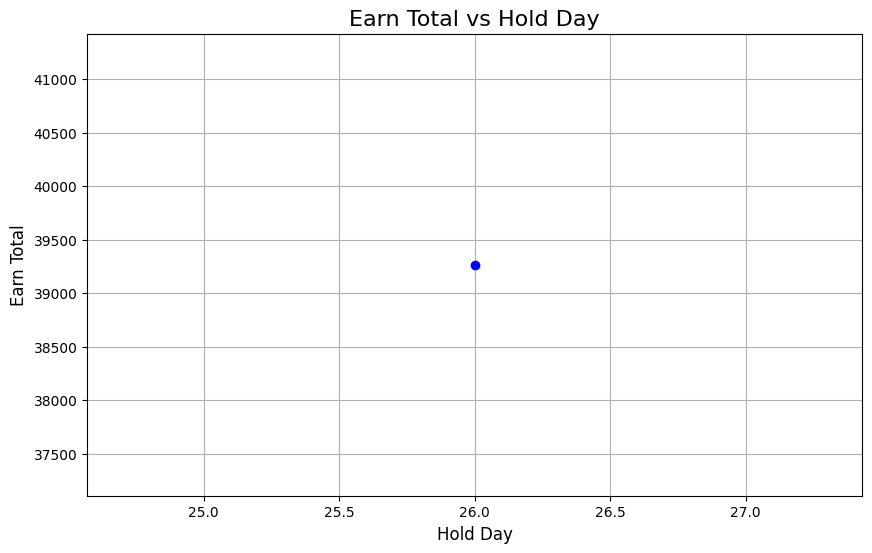

In [19]:
import matplotlib.pyplot as plt

# 假設你有一個 DataFrame 叫 earm_total，裡面包含 hold_day 和 earn_total 兩列
# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(earm_total['MA60_count'], earm_total['earn_total'], marker='o', linestyle='-', color='b')

# 設置標題和標籤
plt.title('Earn Total vs Hold Day', fontsize=16)
plt.xlabel('Hold Day', fontsize=12)
plt.ylabel('Earn Total', fontsize=12)

# 顯示網格線
plt.grid(True)

# 顯示圖表
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_14948\376940125.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MA_count_list_adj['date'] = pd.to_datetime(MA_count_list_adj['date'])


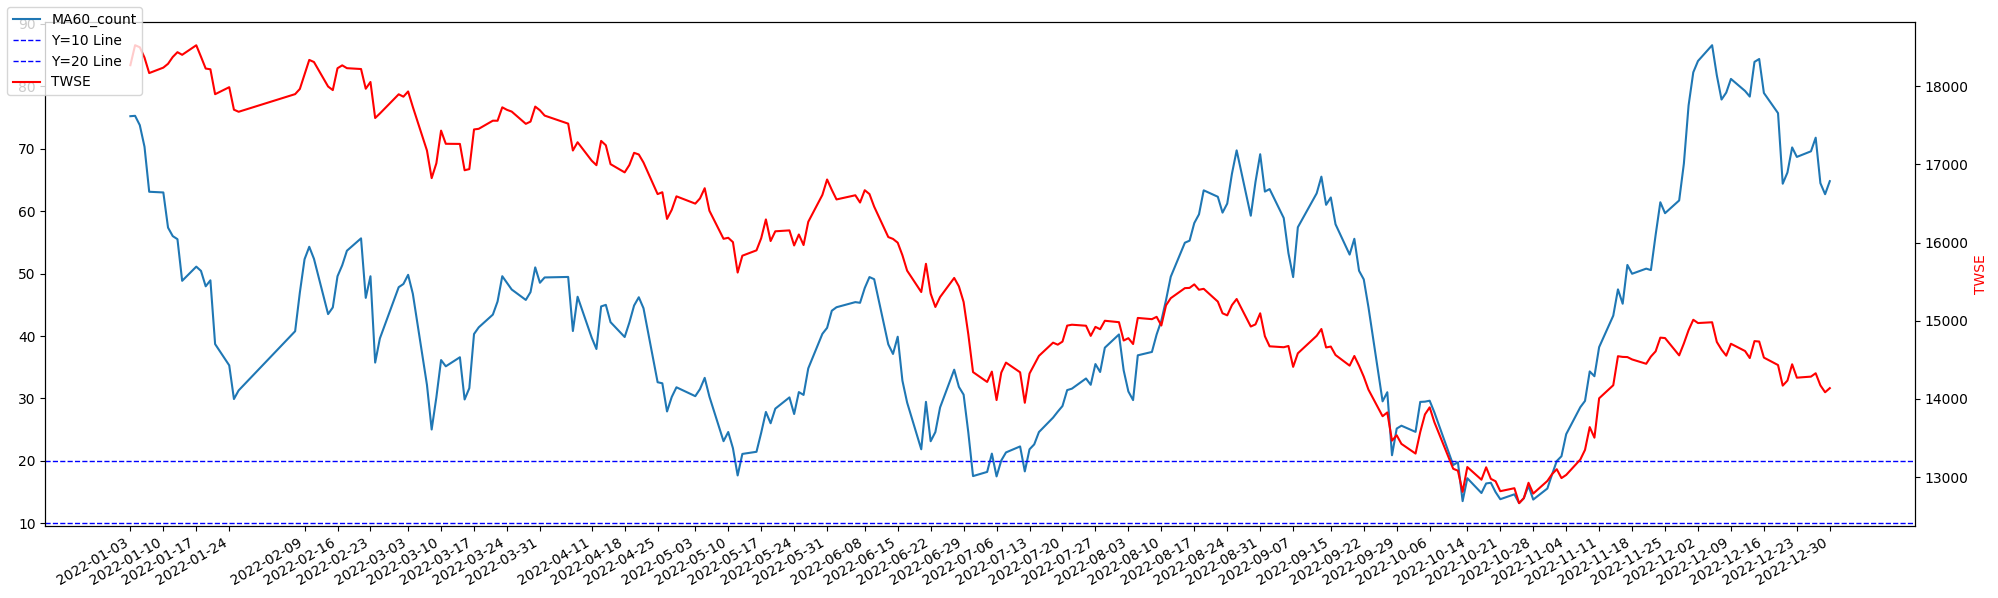

In [21]:
#只看最近
today = datetime.now().date()
one_month_ago = today - timedelta(days=200)

# 格式化日期 (Default)
# today_str = today.strftime('%Y-%m-%d')
# one_month_ago = one_month_ago.strftime('%Y-%m-%d')

today_str = '2022-12-31'
one_month_ago = '2022-01-01'


#疊圖加權指數
twse_index = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數'].copy()
twse_index['Date'] = pd.to_datetime(twse_index['Date'])
twse_index_adj = twse_index[ (twse_index['Date'] >= one_month_ago) &  (twse_index['Date'] <= today_str) ]

MA_count_list_adj = MA_count_list[(MA_count_list['date'] >= one_month_ago) & (MA_count_list['date'] <= today_str)]
MA_count_list_adj['date'] = pd.to_datetime(MA_count_list_adj['date'])

# 設置圖表
fig, ax1 = plt.subplots(figsize=(20, 6))

# 繪製每條MA線
for column in MA_count_list_adj.columns[3:]:
    ax1.plot(MA_count_list_adj['date'], MA_count_list_adj[column], label=column)

ax1.axhline(y=10, color='blue', linestyle='--', linewidth=1, label='Y=10 Line')
ax1.axhline(y=20, color='blue', linestyle='--', linewidth=1, label='Y=20 Line')
# 標題和標籤
# ax1.title('Moving Average Counts Over Time')
# ax1.xlabel('Date')
# ax1.ylabel('Count(%)')
# ax1.legend()
# ax1.grid(True)


# 設置x軸刻度為實際存在的日期
ax1.set_xticks(MA_count_list_adj['date'])

# 格式化 x 轴为日期格式
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

# 自动旋转日期标签以避免重叠
fig.autofmt_xdate()

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 绘制 merged_hist 的折线图
ax2.plot(twse_index_adj['Date'], twse_index_adj['價格指數值'], color='red', linestyle='-', label='TWSE')
ax2.set_xticks(twse_index_adj['Date'])

# 设置第二个 y 轴的标签
ax2.set_ylabel('TWSE', color='red')

ax1.set_xticks(ax1.get_xticks()[::5])  # 每隔5个标签显示一个

#fig.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0))
fig.legend(loc='upper left')
# 自动调整布局以适应标签
fig.tight_layout()

# 显示图表
plt.show()


In [91]:
MA_count_list_adj

,date,MA5_count,MA20_count,MA60_count
0,2024-09-13,75.74,32.56,28.41
0,2024-09-12,59.03,26.74,25.93
0,2024-09-11,28.73,19.30,22.80
0,2024-09-10,25.77,19.78,23.07
0,2024-09-09,29.23,25.46,25.84
...,...,...,...,...
0,2022-01-07,25.57,45.39,63.10
0,2022-01-06,30.88,56.01,70.31
0,2022-01-05,34.89,60.32,73.77
0,2022-01-04,45.44,68.93,75.26


In [100]:
# 目前看不出意義在哪 個股的RS好像沒什麼好看的?


# tt = stock_df_raw[stock_df_raw['證券名稱'] == '信驊']
# import pandas as pd
# import matplotlib.pyplot as plt


# # 示例数据
# data = {
#     'date': tt['Date'],
#     '60RS_rank': tt['60RS_rank']
# }
# tt_df = pd.DataFrame(data)

# # 确保日期列是日期类型
# tt_df['date'] = pd.to_datetime(tt_df['date'])

# # 创建图表
# plt.figure(figsize=(14, 7))
# plt.plot(tt_df['date'], tt_df['60RS_rank'], color='skyblue')

# # 设置标题和标签
# plt.title('60RS Rank Over Time')
# plt.xlabel('Date')
# plt.ylabel('60RS Rank')

# # 显示图表
# plt.show()

# 可能需要60RS_RANK

In [ ]:
# 個股濾網 (技術面)

#股價大於 60MA

#twse_df_raw
#stock_df_raw
#sub_category_list







In [26]:

#temp = sub_category_list[sub_category_list['sub_category'] == '記憶體']
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
temp1 = stock_df_raw[stock_df_raw['Date']=='2024-08-06']
temp2 = stock_df_raw[stock_df_raw['Date']=='2024-08-13']

temp3 = pd.merge(temp1, temp2, on='證券代號', how='inner')  # 全部股票
temp3['收盤價_y']/temp3['收盤價_x']

# Remove rows where any column contains 0
temp3 = temp3[(temp3 != 0).all(axis=1)]


temp3['Price_Difference'] = temp3['收盤價_y']/temp3['收盤價_x']
temp3.sort_values(by=['Price_Difference'], ascending=False, inplace=True)
temp3[['證券代號','證券名稱_x','收盤價_x','收盤價_y','Price_Difference']].head(50)
# cols = ['證券代號', 'stock_name', 'sub_category','20RS_rank','Date']
# temp3 = temp3[cols]
# temp3.sort_values(by=['20RS_rank'], inplace=True)
# temp3

,證券代號,證券名稱_x,收盤價_x,收盤價_y,Price_Difference
717,3303,岱稜,40.85,59.90,1.466340
1561,6754,匯僑設計,60.00,85.10,1.418333
692,3230,錦明,20.10,27.95,1.390547
667,3167,大量,58.90,81.10,1.376910
998,4576,大銀微系統,67.10,91.00,1.356185
1731,8374,羅昇,100.00,134.50,1.345000
690,3228,金麗科,202.50,272.00,1.343210
1651,8043,蜜望實,31.90,42.60,1.335423
970,4534,慶騰,21.50,28.40,1.320930
619,3046,建碁,49.00,64.70,1.320408
